# Прогнозирование оттока клиентов

Требуется создать модель бинарной классификации с метрикой качества ROC-AUC >0.88

# Описание данных    
Данные состоят из файлов, полученных из разных источников:  
* contract.csv — информация о договоре;
* personal.csv — персональные данные клиента;
* internet.csv — информация об интернет-услугах;
* phone.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.


BeginDate – дата начала пользования услугами,  
EndDate – дата окончания пользования услугами,  
Type – тип оплаты: ежемесячный, годовой и тд,  
PaperlessBilling – безналичный расчет,  
PaymentMethod – способ оплаты,  
MonthlyCharges – ежемесячные траты на услуги,  
TotalCharges – всего потрачено денег на услуги  
Dependents – наличие иждивенцев  
Senior Citizen – наличие пенсионного статуса по возрасту  
Partner – наличие супруга(и)  
MultipleLines – наличие возможности ведения параллельных линий во время звонка  



In [1]:
#импортируем используемые библиотеки
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

In [2]:
contact = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/final_provider/contract.csv')
internet = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/final_provider/internet.csv')
personal = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/final_provider/personal.csv')
phone = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/final_provider/phone.csv')


Посмотрим на данные, изучим возможные пропуски и подумаем, что с этим делать

In [3]:
display(contact.head())
print(contact.info())
print(contact.describe())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [4]:
display(internet.head())
print(internet.info())
print(internet.describe())

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     5569-OUICF     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streamin

In [5]:
display(personal.head())
print(personal.info())
print(personal.describe())

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [6]:
display(phone.head())
print(phone.info())
print(phone.describe())

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     0719-SYFRB            No
freq             1          3390


Проверим пропуски:

In [7]:
print(contact['customerID'].isna().sum(), '\n')
print(contact['EndDate'].isna().sum(), '\n')


0 

0 



Пропусков нет.

In [8]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
print(contact.duplicated().sum())

0


In [10]:
print(contact[contact['BeginDate']=='2020-02-01'].count(), '\n')

print('Дата заключения последнего контракта:' , contact['BeginDate'].max())

customerID          11
BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
dtype: int64 

Дата заключения последнего контракта: 2020-02-01


Данные собраны вплоть до 2020-02-01, нас интересует отток клиентов, поэтому предлагаю исключить из рассмотрения все контракты, заключенные 2020-02-01 - их всего 11.  

In [11]:
print(len(contact))



contact = contact.drop(contact[contact['BeginDate']=='2020-02-01'].index)

print(len(contact))

7043
7032


In [12]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [13]:
#изменяем тип данных на datetime:

contact['BeginDate'] = pd.to_datetime(contact['BeginDate'], format='%Y-%m-%d')

In [14]:
contact['EndDate'] = contact['EndDate'].replace('No', '2020-02-01')

In [15]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [16]:
#contact['LifeTime'] = 
print(contact.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 494.4+ KB
None


In [17]:
contact['EndDate'] = pd.to_datetime(contact['EndDate'], format='%Y-%m-%d')


    

In [18]:
contact['LifeTime'] = contact['EndDate']-contact['BeginDate']

In [19]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61 days


In [20]:
def Binary_column(row):
    if 'Yes' in row:
        return 1
    else: 
        return 0

In [21]:
contact['PaperlessBilling'] = contact['PaperlessBilling'].apply(Binary_column)

In [22]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61 days


In [23]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [24]:
internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [25]:
internet['OnlineSecurity'] = internet['OnlineSecurity'].apply(Binary_column)
internet['OnlineBackup'] = internet['OnlineBackup'].apply(Binary_column)
internet['DeviceProtection'] = internet['DeviceProtection'].apply(Binary_column)
internet['TechSupport'] = internet['TechSupport'].apply(Binary_column)
internet['StreamingTV'] = internet['StreamingTV'].apply(Binary_column)
internet['StreamingMovies'] = internet['StreamingMovies'].apply(Binary_column)



In [26]:
internet.head()


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


In [27]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [28]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [29]:
personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [30]:
personal['Dependents'] = personal['Dependents'].apply(Binary_column)
personal['Partner'] = personal['Partner'].apply(Binary_column)



In [31]:
contact.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,LifeTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61 days


In [32]:
phone['MultipleLines'] = phone['MultipleLines'].apply(Binary_column)

In [33]:
#приводим к нижнему регистру
contact.columns = map(str.lower, contact.columns)
internet.columns = map(str.lower, internet.columns)
personal.columns = map(str.lower, personal.columns)
phone.columns = map(str.lower, phone.columns)



In [34]:
#переведем категориальные переменные в вещественные методом OHE
#таблица personal
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


In [35]:
personal = pd.get_dummies(data=personal, columns=['gender'], drop_first=True)

In [36]:
personal.head()

,customerid,seniorcitizen,partner,dependents,gender_Male
0,7590-VHVEG,0,1,0,0
1,5575-GNVDE,0,0,0,1
2,3668-QPYBK,0,0,0,1
3,7795-CFOCW,0,0,0,1
4,9237-HQITU,0,0,0,0


In [37]:
contact.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,lifetime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31 days
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.5,1036 days
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61 days
3,7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371 days
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61 days


In [38]:
#таблица contact
contact = pd.get_dummies(data=contact, columns=['type', 'paymentmethod'], drop_first=True)

In [39]:
contact.head()

,customerid,begindate,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,2020-01-01,2020-02-01,1,29.85,29.85,31 days,0,0,0,1,0
1,5575-GNVDE,2017-04-01,2020-02-01,0,56.95,1889.5,1036 days,1,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,1,53.85,108.15,61 days,0,0,0,0,1
3,7795-CFOCW,2016-05-01,2020-02-01,0,42.30,1840.75,1371 days,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,1,70.70,151.65,61 days,0,0,0,1,0


In [40]:
#таблица internet
internet = pd.get_dummies(data=internet, columns=['internetservice'])

In [41]:
internet.head()

,customerid,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic
0,7590-VHVEG,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,1,0,0,0,1,0
2,3668-QPYBK,1,1,0,0,0,0,1,0
3,7795-CFOCW,1,0,1,1,0,0,1,0
4,9237-HQITU,0,0,0,0,0,0,0,1


In [42]:
#сформулируем целевой признак:
def leaver(row):
    if '2020-02-01' in row:
        return 0
    else: return 1

In [43]:
contact['enddate'] = contact['enddate'].astype(str)
contact['enddate'] = contact['enddate'].apply(leaver)

In [44]:
contact.head()

,customerid,begindate,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,2020-01-01,0,1,29.85,29.85,31 days,0,0,0,1,0
1,5575-GNVDE,2017-04-01,0,0,56.95,1889.5,1036 days,1,0,0,0,1
2,3668-QPYBK,2019-10-01,1,1,53.85,108.15,61 days,0,0,0,0,1
3,7795-CFOCW,2016-05-01,0,0,42.30,1840.75,1371 days,1,0,0,0,0
4,9237-HQITU,2019-09-01,1,1,70.70,151.65,61 days,0,0,0,1,0


In [45]:
#удалим столбец begindate, иначе будет утечка данных

contact = contact.drop('begindate', axis=1)

In [46]:
contact.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,31 days,0,0,0,1,0
1,5575-GNVDE,0,0,56.95,1889.5,1036 days,1,0,0,0,1
2,3668-QPYBK,1,1,53.85,108.15,61 days,0,0,0,0,1
3,7795-CFOCW,0,0,42.30,1840.75,1371 days,1,0,0,0,0
4,9237-HQITU,1,1,70.70,151.65,61 days,0,0,0,1,0


In [47]:
contact['totalcharges'] = contact['totalcharges'].astype(float)

In [48]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype          
---  ------                                 --------------  -----          
 0   customerid                             7032 non-null   object         
 1   enddate                                7032 non-null   int64          
 2   paperlessbilling                       7032 non-null   int64          
 3   monthlycharges                         7032 non-null   float64        
 4   totalcharges                           7032 non-null   float64        
 5   lifetime                               7032 non-null   timedelta64[ns]
 6   type_One year                          7032 non-null   uint8          
 7   type_Two year                          7032 non-null   uint8          
 8   paymentmethod_Credit card (automatic)  7032 non-null   uint8          
 9   paymentmethod_Electronic check         7032 non-null

In [49]:
#contact['lifetime'] = contact['lifetime'].astype(str)

In [50]:
contact.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,31 days,0,0,0,1,0
1,5575-GNVDE,0,0,56.95,1889.50,1036 days,1,0,0,0,1
2,3668-QPYBK,1,1,53.85,108.15,61 days,0,0,0,0,1
3,7795-CFOCW,0,0,42.30,1840.75,1371 days,1,0,0,0,0
4,9237-HQITU,1,1,70.70,151.65,61 days,0,0,0,1,0


In [51]:
contact['lifetime'] = contact['lifetime'].dt.days

In [52]:
contact.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,31,0,0,0,1,0
1,5575-GNVDE,0,0,56.95,1889.50,1036,1,0,0,0,1
2,3668-QPYBK,1,1,53.85,108.15,61,0,0,0,0,1
3,7795-CFOCW,0,0,42.30,1840.75,1371,1,0,0,0,0
4,9237-HQITU,1,1,70.70,151.65,61,0,0,0,1,0


In [53]:
contact.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerid                             7032 non-null   object 
 1   enddate                                7032 non-null   int64  
 2   paperlessbilling                       7032 non-null   int64  
 3   monthlycharges                         7032 non-null   float64
 4   totalcharges                           7032 non-null   float64
 5   lifetime                               7032 non-null   int64  
 6   type_One year                          7032 non-null   uint8  
 7   type_Two year                          7032 non-null   uint8  
 8   paymentmethod_Credit card (automatic)  7032 non-null   uint8  
 9   paymentmethod_Electronic check         7032 non-null   uint8  
 10  paymentmethod_Mailed check             7032 non-null   uint8  
dtypes: f

In [54]:
#соединим таблицы в один большой df
print('Всего строк в таблице contact:',len(contact), '\n')

print('Всего строк в таблице internet:',len(internet), '\n')


internet.info()
print(internet['onlinesecurity'].value_counts())

Всего строк в таблице contact: 7032 

Всего строк в таблице internet: 5517 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   customerid                   5517 non-null   object
 1   onlinesecurity               5517 non-null   int64 
 2   onlinebackup                 5517 non-null   int64 
 3   deviceprotection             5517 non-null   int64 
 4   techsupport                  5517 non-null   int64 
 5   streamingtv                  5517 non-null   int64 
 6   streamingmovies              5517 non-null   int64 
 7   internetservice_DSL          5517 non-null   uint8 
 8   internetservice_Fiber optic  5517 non-null   uint8 
dtypes: int64(6), object(1), uint8(2)
memory usage: 312.6+ KB
0    3498
1    2019
Name: onlinesecurity, dtype: int64


In [55]:
print(type(internet))

<class 'pandas.core.frame.DataFrame'>


In [56]:
contact_internet = contact.merge(internet, on='customerid', how='left')

In [57]:
contact_internet.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic
0,7590-VHVEG,0,1,29.85,29.85,31,0,0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,0,0,56.95,1889.50,1036,1,0,0,0,1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3668-QPYBK,1,1,53.85,108.15,61,0,0,0,0,1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,7795-CFOCW,0,0,42.30,1840.75,1371,1,0,0,0,0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
4,9237-HQITU,1,1,70.70,151.65,61,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [58]:
len(contact_internet)

7032

In [59]:
contact_internet_personal = contact_internet.merge(personal, on='customerid', how='left')

In [60]:
contact_internet_personal.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,deviceprotection,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic,seniorcitizen,partner,dependents,gender_Male
0,7590-VHVEG,0,1,29.85,29.85,31,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0
1,5575-GNVDE,0,0,56.95,1889.50,1036,1,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1
2,3668-QPYBK,1,1,53.85,108.15,61,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,1
3,7795-CFOCW,0,0,42.30,1840.75,1371,1,0,0,0,...,1.0,1.0,0.0,0.0,1.0,0.0,0,0,0,1
4,9237-HQITU,1,1,70.70,151.65,61,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0


In [61]:
len(contact_internet_personal)

7032

In [62]:
data_full = contact_internet_personal.merge(phone, on='customerid', how='left')

In [63]:
data_full.head()

,customerid,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic,seniorcitizen,partner,dependents,gender_Male,multiplelines
0,7590-VHVEG,0,1,29.85,29.85,31,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0,1,0,0,NaN
1,5575-GNVDE,0,0,56.95,1889.50,1036,1,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
2,3668-QPYBK,1,1,53.85,108.15,61,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
3,7795-CFOCW,0,0,42.30,1840.75,1371,1,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,NaN
4,9237-HQITU,1,1,70.70,151.65,61,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0


In [64]:
data_full = data_full.fillna(0)

In [65]:
data_full = data_full.drop('customerid', axis=1)


## Если модель покажет высокую корелляцию -  удалим monthly charges and totalcharges

In [66]:
data_full.head()

,enddate,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,...,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic,seniorcitizen,partner,dependents,gender_Male,multiplelines
0,0,1,29.85,29.85,31,0,0,0,1,0,...,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0.0
1,0,0,56.95,1889.50,1036,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
2,1,1,53.85,108.15,61,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
3,0,0,42.30,1840.75,1371,1,0,0,0,0,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0.0
4,1,1,70.70,151.65,61,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0.0


In [67]:
#разбиваем на тренировояную, валидационную и тестовую выборки в отношении 6:2:2

In [68]:
train_valid, test = train_test_split(data_full, shuffle=True, random_state=12345, test_size=0.2)
train, valid = train_test_split(train_valid, shuffle=True, random_state=12345, test_size=0.25)



In [69]:
features_train = train.drop('enddate', axis = 1)

In [70]:
features_train.head()

,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,onlinesecurity,...,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic,seniorcitizen,partner,dependents,gender_Male,multiplelines
3299,1,109.95,7634.25,2102,0,1,0,1,0,0.0,...,1.0,1.0,1.0,0.0,1.0,1,1,0,1,1.0
4456,0,81.70,858.60,365,0,0,0,0,0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0.0
647,0,89.50,161.50,61,0,0,0,1,0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0,0,0,1.0
3781,1,95.30,5817.70,1767,0,0,0,1,0,0.0,...,1.0,1.0,1.0,0.0,1.0,0,0,0,0,0.0
3754,1,73.60,232.50,92,0,0,1,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0,0,0,1,0.0


In [71]:
target_train = train['enddate']

In [72]:
test_features = test.drop('enddate', axis = 1)
test_target= test['enddate']

In [73]:
valid_features = valid.drop('enddate', axis=1)
valid_target = valid['enddate']

In [74]:
data_full['enddate'].value_counts()

0    5163
1    1869
Name: enddate, dtype: int64

In [75]:
def upsample(features_train, target_train, repeat):
    features_zeros = features_train[target_train==0]
    features_ones = features_train[target_train==1]
    target_zeros = target_train[target_train==0]
    target_ones = target_train[target_train==1]
    
    features_upsampled = pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros]+[target_ones]*repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
    
    

In [76]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 2)

In [77]:
features_train_upsampled['onlinesecurity'] = features_train_upsampled['onlinesecurity'].astype(int)
features_train_upsampled['onlinebackup'] = features_train_upsampled['onlinebackup'].astype(int)
features_train_upsampled['deviceprotection'] = features_train_upsampled['deviceprotection'].astype(int)
features_train_upsampled['techsupport'] = features_train_upsampled['techsupport'].astype(int)
features_train_upsampled['streamingtv'] = features_train_upsampled['streamingtv'].astype(int)
features_train_upsampled['streamingmovies'] = features_train_upsampled['streamingmovies'].astype(int)
features_train_upsampled['internetservice_DSL'] = features_train_upsampled['internetservice_DSL'].astype(int)
features_train_upsampled['internetservice_Fiber optic'] = features_train_upsampled['internetservice_Fiber optic'].astype(int)
features_train_upsampled['multiplelines'] = features_train_upsampled['multiplelines'].astype(int)
features_train_upsampled['monthlycharges'] = features_train_upsampled['monthlycharges'].astype(int)
features_train_upsampled['totalcharges'] = features_train_upsampled['totalcharges'].astype(int)





In [78]:
LR = LogisticRegression(n_jobs=-1)

In [79]:
LR.fit(features_train_upsampled, target_train_upsampled)

LogisticRegression(n_jobs=-1)

In [80]:
probabilities = LR.predict_proba(valid_features)
probabilities_ones = probabilities[:, 1]

In [81]:
print(probabilities, '\n')

print(probabilities_ones)

[[0.9912857  0.0087143 ]
 [0.33574179 0.66425821]
 [0.96685411 0.03314589]
 ...
 [0.92897261 0.07102739]
 [0.69093943 0.30906057]
 [0.38251399 0.61748601]] 

[0.0087143  0.66425821 0.03314589 ... 0.07102739 0.30906057 0.61748601]


In [82]:
roc_auc_score(valid_target, probabilities_ones)

0.8455504650839929

In [83]:
RF = RandomForestClassifier(n_jobs=-1)

In [84]:
RF.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(n_jobs=-1)

In [85]:
probs_RF = RF.predict_proba(valid_features)
probs_RF_ones = probs_RF[:,1]

In [86]:
roc_auc_score(valid_target, probs_RF_ones)

0.8401604784014891

Подбираем гиперпараметры для случайного леса, используя GridSearchCV

In [87]:
# param_grid = {
#     'bootstrap': [True, False],
#     'max_depth': range(10, 30, 2),
#     'max_features': ['auto'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [2, 3, 4],
#     'n_estimators': range(10, 200, 10)
# }
# RF = RandomForestClassifier(n_jobs=-1)
# grid_search = GridSearchCV(estimator = RF, param_grid = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 2, scoring = 'roc_auc')

In [88]:
# # Fit the grid search to the data
# grid_search.fit(features_train_upsampled, target_train_upsampled)



In [89]:
# grid_search.best_params_

Лучшие параметры:   
max_depth= 18,  
max_features = 'auto',  
min_samples_leaf = 1,  
min_samples_split = 2,  
n_estimators = 140)  

In [90]:
RF_final = RandomForestClassifier(bootstrap= False, 
 max_depth= 18,
 max_features = 'auto',
 min_samples_leaf = 1,
 min_samples_split = 2,
 n_estimators = 140)

In [91]:
RF_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(bootstrap=False, max_depth=18, n_estimators=140)

In [92]:
probs = RF_final.predict_proba(valid_features)

In [93]:
probs_ones=probs[:,1]

In [94]:
roc_auc_score(valid_target, probs_ones)

0.8384070937520889

ROC_AUC на валидационной выборке: .836193509905852

In [95]:
probs_test = RF_final.predict_proba(test_features)

In [96]:
probs_test_ones = probs_test[:,1]

In [97]:
roc_auc_score(test_target,probs_test_ones)

0.8411007873694518

ROC__AUC на тестовой выборке: 0.840391950881201

Попробуем подобрать гиперпараметры вручную:

In [98]:
# depths = {}
# for depth in range(8,25,1):
#     model = RandomForestClassifier(n_jobs=-1, max_depth = depth)
#     model.fit(features_train_upsampled, target_train_upsampled)
#     probs_ones = model.predict_proba(valid_features)[:,1]
#     result = roc_auc_score(valid_target, probs_ones)
#     depths.update({depth:result})
    
    
    

In [99]:
#scores={}

#for n_estimator in range(1,200):
#    for min_samples_split in range (2,4):
#        model_TR = RandomForestRegressor(n_estimators  = n_estimator, max_depth=None,
#                                        min_samples_split=min_samples_split,
#                                        min_samples_leaf=1,
#                                        n_jobs=-1, random_state=state)
#        res = sum(cross_val_score(model_TR, features_train_cleared, target_train_cleared ,
#                         cv=5, scoring=smape_score)/5)
#        scores.update({(n_estimator,n_neighbor,min_samples_split):res})




In [100]:
# print(max(depths, key=depths.get))


In [101]:
# estimators = {}
# for estimator in range(10,200,1):
#     model = RandomForestClassifier(n_jobs=-1, max_depth = 8, n_estimators=estimator)
#     model.fit(features_train_upsampled, target_train_upsampled)
#     probs_ones = model.predict_proba(valid_features)[:,1]
#     result = roc_auc_score(valid_target, probs_ones)
#     estimators.update({estimator:result})

In [102]:
# print(max(estimators, key=estimators.get))



Лучшие параметры:  
max_depth = 8  
n_estimators= 48  

In [103]:
model = RandomForestClassifier(n_jobs=-1, max_depth = 8, n_estimators=48)

In [104]:
model.fit(features_train_upsampled, target_train_upsampled)
probs_ones = model.predict_proba(valid_features)[:,1]
result = roc_auc_score(valid_target, probs_ones)

In [105]:
print(result)

0.8608784405674591


In [106]:
probs_ones = model.predict_proba(test_features)[:,1]
result = roc_auc_score(test_target, probs_ones)

In [107]:
print(result)

0.864224665469974


ROC_AUC на тестовой выборке: 0.8604663022193211

Попробуем бустинг

In [108]:
cat_features = [0, 1]


model_CB = CatBoostClassifier(iterations=2,
                           learning_rate=1,
                           depth=2)

model_CB.fit(features_train_upsampled, target_train_upsampled)


probs_ones = model_CB.predict_proba(valid_features)[:,1]

roc_auc_score(valid_target, probs_ones)



0:	learn: 0.5487592	total: 59.5ms	remaining: 59.5ms
1:	learn: 0.5132805	total: 61.2ms	remaining: 0us


0.8063576904684776

ROC_AUC на валидационной:   
0.8227127585728169

Попробуем подобрать лучшие гиперпараметры:

In [109]:
# model = CatBoostClassifier(custom_metric=['AUC:hints=skip_train~false'])

# params = {'depth':[3,5,7],
#           'iterations':[100,250,500],
#           'learning_rate':[0.01,0.02, 0.03]}


# grid_search_result = model.grid_search(params,
#                                        X=features_train_upsampled, 
#                                        y=target_train_upsampled, 
#                                        plot=True)



In [110]:
model_CB_final = CatBoostClassifier(depth=7, learning_rate=0.03, iterations=500)
#модель с лучшими параметрами

model_CB_final.fit(features_train_upsampled, target_train_upsampled)




0:	learn: 0.6797545	total: 4.63ms	remaining: 2.31s
1:	learn: 0.6674961	total: 8.53ms	remaining: 2.12s
2:	learn: 0.6536945	total: 11.3ms	remaining: 1.87s
3:	learn: 0.6408642	total: 14.8ms	remaining: 1.83s
4:	learn: 0.6283618	total: 17.7ms	remaining: 1.76s
5:	learn: 0.6170747	total: 20.9ms	remaining: 1.72s
6:	learn: 0.6049064	total: 24.6ms	remaining: 1.73s
7:	learn: 0.5958433	total: 28.3ms	remaining: 1.74s
8:	learn: 0.5869457	total: 31.8ms	remaining: 1.74s
9:	learn: 0.5772523	total: 34.6ms	remaining: 1.7s
10:	learn: 0.5694654	total: 37.4ms	remaining: 1.66s
11:	learn: 0.5626754	total: 40.4ms	remaining: 1.64s
12:	learn: 0.5570666	total: 44.6ms	remaining: 1.67s
13:	learn: 0.5511217	total: 48.7ms	remaining: 1.69s
14:	learn: 0.5453232	total: 52.6ms	remaining: 1.7s
15:	learn: 0.5398001	total: 55.8ms	remaining: 1.69s
16:	learn: 0.5344114	total: 58.4ms	remaining: 1.66s
17:	learn: 0.5291997	total: 61.5ms	remaining: 1.65s
18:	learn: 0.5244626	total: 64.2ms	remaining: 1.62s
19:	learn: 0.5189342	tot

161:	learn: 0.3654696	total: 536ms	remaining: 1.12s
162:	learn: 0.3648649	total: 538ms	remaining: 1.11s
163:	learn: 0.3645263	total: 541ms	remaining: 1.11s
164:	learn: 0.3642953	total: 545ms	remaining: 1.1s
165:	learn: 0.3638277	total: 548ms	remaining: 1.1s
166:	learn: 0.3633492	total: 552ms	remaining: 1.1s
167:	learn: 0.3629832	total: 555ms	remaining: 1.1s
168:	learn: 0.3623846	total: 559ms	remaining: 1.09s
169:	learn: 0.3621512	total: 563ms	remaining: 1.09s
170:	learn: 0.3613939	total: 567ms	remaining: 1.09s
171:	learn: 0.3606976	total: 571ms	remaining: 1.09s
172:	learn: 0.3604487	total: 574ms	remaining: 1.08s
173:	learn: 0.3597801	total: 577ms	remaining: 1.08s
174:	learn: 0.3595216	total: 580ms	remaining: 1.08s
175:	learn: 0.3591933	total: 582ms	remaining: 1.07s
176:	learn: 0.3584854	total: 585ms	remaining: 1.07s
177:	learn: 0.3576939	total: 588ms	remaining: 1.06s
178:	learn: 0.3573784	total: 591ms	remaining: 1.06s
179:	learn: 0.3571042	total: 594ms	remaining: 1.06s
180:	learn: 0.35

322:	learn: 0.3023677	total: 1.13s	remaining: 617ms
323:	learn: 0.3019990	total: 1.13s	remaining: 615ms
324:	learn: 0.3016131	total: 1.14s	remaining: 612ms
325:	learn: 0.3011923	total: 1.14s	remaining: 608ms
326:	learn: 0.3007669	total: 1.14s	remaining: 605ms
327:	learn: 0.3003519	total: 1.15s	remaining: 602ms
328:	learn: 0.2999459	total: 1.15s	remaining: 598ms
329:	learn: 0.2995524	total: 1.15s	remaining: 595ms
330:	learn: 0.2991843	total: 1.16s	remaining: 591ms
331:	learn: 0.2990070	total: 1.16s	remaining: 589ms
332:	learn: 0.2984513	total: 1.17s	remaining: 586ms
333:	learn: 0.2981672	total: 1.17s	remaining: 582ms
334:	learn: 0.2979500	total: 1.17s	remaining: 578ms
335:	learn: 0.2977770	total: 1.18s	remaining: 575ms
336:	learn: 0.2974151	total: 1.18s	remaining: 572ms
337:	learn: 0.2971831	total: 1.19s	remaining: 568ms
338:	learn: 0.2968050	total: 1.19s	remaining: 564ms
339:	learn: 0.2964960	total: 1.19s	remaining: 560ms
340:	learn: 0.2963017	total: 1.19s	remaining: 557ms
341:	learn: 

483:	learn: 0.2543405	total: 1.71s	remaining: 56.5ms
484:	learn: 0.2540277	total: 1.71s	remaining: 53ms
485:	learn: 0.2538326	total: 1.72s	remaining: 49.5ms
486:	learn: 0.2536735	total: 1.72s	remaining: 45.9ms
487:	learn: 0.2534703	total: 1.72s	remaining: 42.4ms
488:	learn: 0.2533518	total: 1.73s	remaining: 38.9ms
489:	learn: 0.2532014	total: 1.73s	remaining: 35.4ms
490:	learn: 0.2530009	total: 1.74s	remaining: 31.8ms
491:	learn: 0.2526636	total: 1.74s	remaining: 28.3ms
492:	learn: 0.2525286	total: 1.74s	remaining: 24.8ms
493:	learn: 0.2521510	total: 1.75s	remaining: 21.2ms
494:	learn: 0.2516127	total: 1.75s	remaining: 17.7ms
495:	learn: 0.2511754	total: 1.75s	remaining: 14.1ms
496:	learn: 0.2508716	total: 1.75s	remaining: 10.6ms
497:	learn: 0.2505254	total: 1.76s	remaining: 7.06ms
498:	learn: 0.2502990	total: 1.76s	remaining: 3.53ms
499:	learn: 0.2500920	total: 1.77s	remaining: 0us


In [111]:
probs_ones = model_CB_final.predict_proba(valid_features)[:,1]

roc_auc_score(valid_target, probs_ones)

0.8924612172911492

In [112]:
probs_test_ones = model_CB_final.predict_proba(test_features)[:,1]

roc_auc_score(test_target, probs_test_ones)

0.8923371715894257

Это лучший результат, оставляем его. 

# Вывод

Данные были проверены на пропуски и дубликаты, неподходящие строки (с датой заключения договора на текущее число 1 февраля 2020) были удалены, был создан новый столбец "Время жизни клиента", ненужные столбцы для модели дропнуты, создана общая сводная таблица, категориальные переменные переведены в количественные, опробованы разные модели и оставлена лучшая со значением ROC_AUC 0.8929108701860313 на тестовой выборке. 


In [113]:
importances = model_CB_final.feature_importances_

In [114]:
importances = pd.Series(importances, index=valid_features.columns)
                               
                               
                               

In [115]:
importances.head()

paperlessbilling     3.750077
monthlycharges       9.397765
totalcharges         8.472738
lifetime            35.254578
type_One year        2.762659
dtype: float64

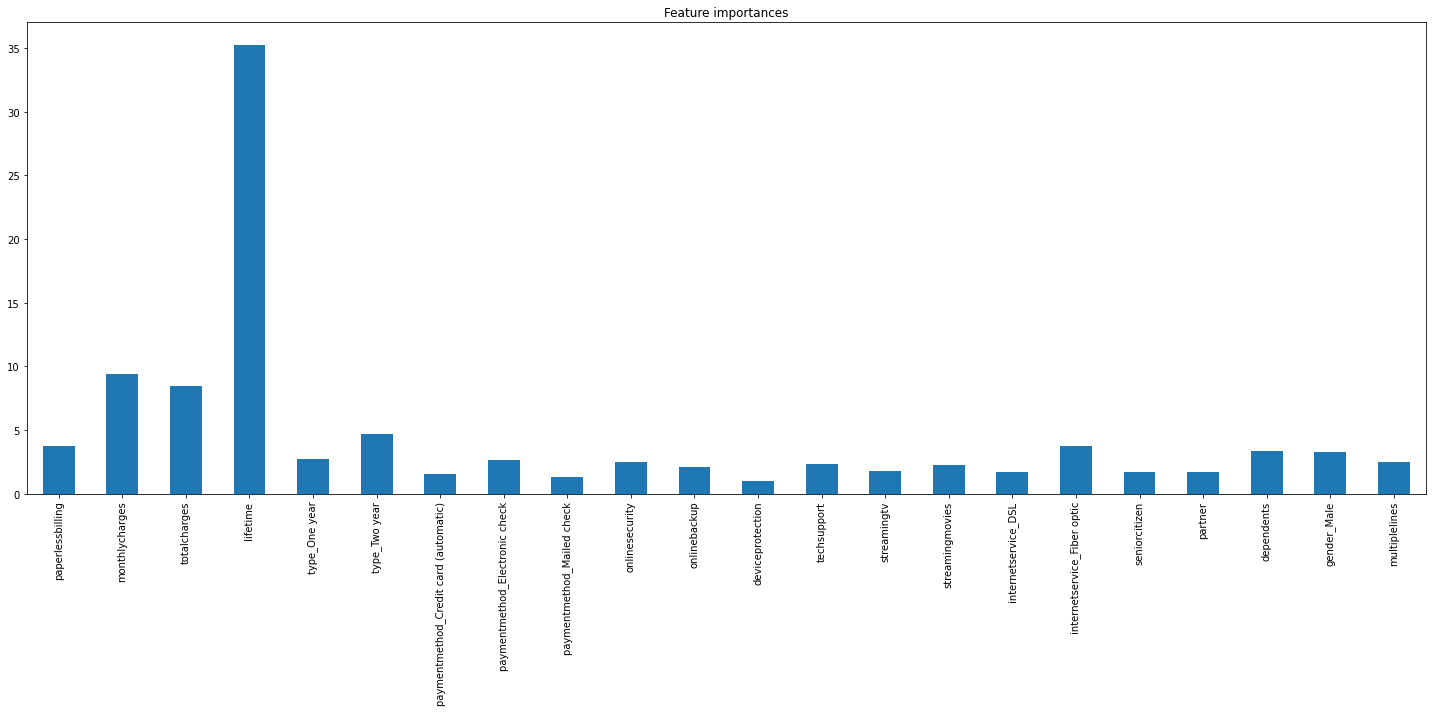

In [116]:
fig, ax = plt.subplots()

importances.plot.bar(ax=ax, figsize=(20,10))
ax.set_title("Feature importances")

fig.tight_layout()

plt.show()

In [117]:
corr_matrix = features_train_upsampled.corr().abs()


display(corr_matrix)

,paperlessbilling,monthlycharges,totalcharges,lifetime,type_One year,type_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,onlinesecurity,...,techsupport,streamingtv,streamingmovies,internetservice_DSL,internetservice_Fiber optic,seniorcitizen,partner,dependents,gender_Male,multiplelines
paperlessbilling,1.000000,0.353859,0.132771,0.010540,0.051789,0.148309,0.004579,0.211518,0.217272,0.012509,...,0.015207,0.231662,0.213884,0.078181,0.326891,0.176699,0.021122,0.108142,0.009411,0.175291
monthlycharges,0.353859,1.000000,0.613242,0.243387,0.029617,0.082512,0.042435,0.266755,0.370395,0.251137,...,0.294896,0.623902,0.609126,0.249166,0.801725,0.230000,0.085155,0.110536,0.003898,0.515074
totalcharges,0.132771,0.613242,1.000000,0.847616,0.235436,0.364224,0.209982,0.070368,0.275926,0.391682,...,0.420839,0.495704,0.484798,0.083005,0.328206,0.084279,0.318129,0.094353,0.008121,0.458220
lifetime,0.010540,0.243387,0.847616,1.000000,0.260313,0.561640,0.250298,0.210050,0.214238,0.334696,...,0.337311,0.284515,0.275288,0.006032,0.009520,0.000144,0.383399,0.192445,0.007573,0.324355
type_One year,0.051789,0.029617,0.235436,0.260313,1.000000,0.235669,0.086966,0.124640,0.002002,0.127488,...,0.140159,0.093484,0.088303,0.050066,0.075664,0.058796,0.112332,0.102929,0.007736,0.020315
type_Two year,0.148309,0.082512,0.364224,0.561640,0.235669,1.000000,0.182442,0.282453,0.007988,0.199435,...,0.246650,0.058863,0.054608,0.039424,0.214138,0.117026,0.257121,0.221615,0.005802,0.087862
paymentmethod_Credit card (automatic),0.004579,0.042435,0.209982,0.250298,0.086966,0.182442,1.000000,0.387860,0.261571,0.126415,...,0.131020,0.044530,0.052973,0.057819,0.050156,0.024440,0.089940,0.077066,0.012935,0.075413
paymentmethod_Electronic check,0.211518,0.266755,0.070368,0.210050,0.124640,0.282453,0.387860,1.000000,0.425707,0.125469,...,0.139847,0.152189,0.158600,0.107557,0.323325,0.182251,0.092923,0.165113,0.011032,0.093475
paymentmethod_Mailed check,0.217272,0.370395,0.275926,0.214238,0.002002,0.007988,0.261571,0.425707,1.000000,0.059685,...,0.055785,0.237776,0.251082,0.053667,0.300190,0.161036,0.084077,0.060723,0.001291,0.234219
onlinesecurity,0.012509,0.251137,0.391682,0.334696,0.127488,0.199435,0.126415,0.125469,0.059685,1.000000,...,0.339923,0.135582,0.138248,0.279561,0.046431,0.046949,0.146586,0.067571,0.010409,0.078390


In [118]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]


In [119]:
print(to_drop)

['lifetime', 'internetservice_Fiber optic']


totalcharges и lifetime - корреляция 0.847616
internetservice_Fiber optic и monthlycharges - корреляция 0.801725


In [120]:
# features_train_upsampled.drop(to_drop, axis=1, inplace=True)

# Отчет

### Исходный план:
1. Подготовим данные: очистим от пропусков, создадим новый столбец 'LifeTime' - количество дней, которые клиент уже использует услуги компании, категориальные переменные переведем в количественные. 
2.  Столбец с целевым признаком переведем в соответствующий для бинарной классификации формат и столбец 'BeginDate' удалим, тк возможна утечка данных, так же как и стобец 'customerID'

3. Создадим общую таблицу, объединив таблицы по ключу customerID

4. Обучим разные модели, подберем разные гиперпараметры

5. Выберем лучшею модель и на основе ее предсказаний и, например, количества денег, которые клиент уже принес компании, попробуем подобрать размер скидки для удержания клиента. Также возможно получится предложить формлу для расчета размера скидки. 




Исходный план был выполнен полностью.  
Трудностей по ходу выполнения работы не было.  
Ключевой момент работы - пришла в голову идея использорвать CatBoostClassifier - как оказалось, он как раз подходит лучше всех для задачи классификации с множеством категориальных переменных.   

Итоговая модель:  
CatBoostClassifier(depth=7, learning_rate=0.03, iterations=500)  
со значением ROC-AUC на валидационной выборке: 
0.8924612172911492  
И со значением на тестовой:
0.8923371715894257  
